In [135]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.filters import threshold_niblack, threshold_sauvola
from mahotas.thresholding import bernsen,rc

In [136]:
path = "/home/mayank/DIP Mini Project/DIPCO2016_dataset/"  # Original Images
path_gt = "/home/mayank/DIP Mini Project/DIPCO2016_Dataset_GT/"  # Ground Truth Images

In [137]:
# Loading images
def import_image(loc1):
    return(np.array(cv2.imread(loc1, 0)))

# Calculating Pixel Frequency 
def create_hist(img):
    hist = {}
    for i in range(0, len(img)):
        for j in range(0, len(img[i])):
            if img[i][j] in hist.keys():
                hist[img[i][j]] += 1
            else:
                hist[img[i][j]] = 1
    return hist

# Tranforming Ground Truth image into True and False
def bin_gt(img):
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] == 0:
                img[i][j] = False
            else:
                img[i][j] = True
    return img

In [138]:
org_img = import_image(path + "1.bmp")
gt_img = import_image(path_gt + "1_gt.bmp")
img_hist = create_hist(org_img)
gt_img = bin_gt(gt_img)
n_pixels = org_img.shape[0]*org_img.shape[1]

# Algorithm 1 - OTSU

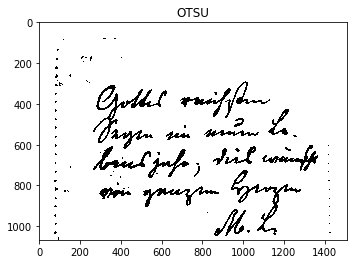

[[1491073, 7657], [7642, 104798]]
0.9319105419945756 0.9320348630380647 0.9319726983703506


In [139]:
master_list = []

for i in range(len(set(org_img.ravel())) - 1):

    T = i

    weight_back_num = 0
    weight_fore_num = 0
    mean_back_num = 0
    mean_fore_num = 0
    wb = 0
    wf = 0
    mb = 0
    mf = 0
    vb = 0
    vf = 0

    j = 0

    for k in img_hist.keys():
        if j > T:
            weight_fore_num += img_hist[k]
            mean_fore_num += k * img_hist[k]
            j += 1
        else:
            weight_back_num += img_hist[k]
            mean_back_num += k * img_hist[k]
            j += 1

    wb = weight_back_num / n_pixels
    mb = mean_back_num / weight_back_num

    t = 0

    wf = 1 - wb
    mf = mean_fore_num / weight_fore_num

    for k in img_hist.keys():
        if t > T:
            vf += ((k - mf) ** 2) * img_hist[k]
            t += 1
        else:
            vb += ((k - mb) ** 2) * img_hist[k]
            t += 1
    # print(vf)
    vb /= weight_back_num
    vf /= weight_fore_num
    
    within_class_variance = wb * vb + wf * vf

    master_list.append(
        {'i': i, 'wbn': weight_back_num, 'wb': wb, 'mbn': mean_back_num, 'mb': mb, 'vb': vb,
         'wfn': weight_fore_num, 'wf': wf, 'mfn': mean_fore_num, 'mf': mf, 'vf': vf,
         'within': within_class_variance})

min = 1000000
index = 0
for k in master_list:
    if k['within'] < min:
        min = k['within']
        index = k['i']

im1 = org_img > index

plt.imshow(im1, cmap='gray')
plt.title('OTSU')
plt.show()

# Calculating Accuracy
tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, im1):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_otsu = [[tn, fp], [fn, tp]]
precision_otsu = tp / (tp + fp)
recall_otsu = tp / (tp + fn)
f_otsu = 2*(precision_otsu*recall_otsu)/(precision_otsu+recall_otsu)
print(cm_otsu)
print(precision_otsu, recall_otsu, f_otsu)

# Algorithm 2 - OTSU with Gaussian Filtering

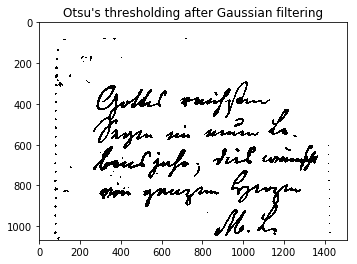

0.8954677992954779 0.9450195659907507 0.9195766371558879


In [140]:
blur = cv2.GaussianBlur(org_img,(5,5),0)
ret3,binary_otsu_gauss = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(binary_otsu_gauss, cmap='gray')
plt.title("Otsu's thresholding after Gaussian filtering")
plt.show()

for i in range(len(binary_otsu_gauss)):
    for j in range(len(binary_otsu_gauss[i])):
        if binary_otsu_gauss[i][j] == 0:
            binary_otsu_gauss[i][j] = False
        else:
            binary_otsu_gauss[i][j] = True

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, binary_otsu_gauss):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_otsu_gauss = [[tn, fp], [fn, tp]]
precision_otsu_gauss = tp / (tp + fp)
recall_otsu_gauss = tp / (tp + fn)
f_otsu_gauss = 2*(precision_otsu_gauss*recall_otsu_gauss)/(precision_otsu_gauss+recall_otsu_gauss)
print(precision_otsu_gauss, recall_otsu_gauss, f_otsu_gauss)

# Algorithm 3 - Bernsen

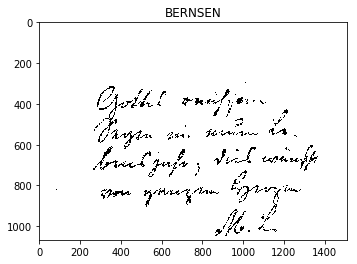

[[1498654, 76], [55333, 57107]]
0.9986709336690974 0.5078886517253647 0.6733402899370958


In [141]:
thresh_bernsen = bernsen(org_img, 25, 114)
binary_bernsen = org_img > thresh_bernsen
plt.imshow(binary_bernsen, cmap='gray')
plt.title('BERNSEN')
plt.show()

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, binary_bernsen):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_bernsen = [[tn, fp], [fn, tp]]
precision_bernsen = tp / (tp + fp)
recall_bernsen = tp / (tp + fn)
f_bernsen = 2*(precision_bernsen*recall_bernsen)/(precision_bernsen+recall_bernsen)
print(cm_bernsen)
print(precision_bernsen, recall_bernsen, f_bernsen)

# Algorithm 4 - Sauvola

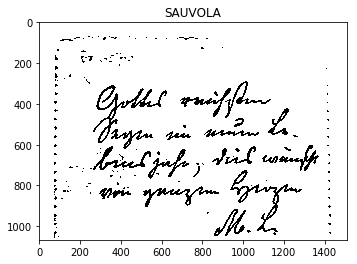

[[1487885, 10845], [8585, 103855]]
0.9054489973844813 0.9236481679117752 0.9144580434974025


In [142]:
window_size = 25
thresh_sauvola = threshold_sauvola(org_img, window_size=window_size)
binary_sauvola = org_img > thresh_sauvola
plt.imshow(binary_sauvola, cmap='gray')
plt.title('SAUVOLA')
plt.show()

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, binary_sauvola):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_sauvola = [[tn, fp], [fn, tp]]
precision_sauvola = tp / (tp + fp)
recall_sauvola = tp / (tp + fn)
f_sauvola = 2*(precision_sauvola*recall_sauvola)/(precision_sauvola+recall_sauvola)
print(cm_sauvola)
print(precision_sauvola, recall_sauvola, f_sauvola)


# Algorithm 5 - NiBlack

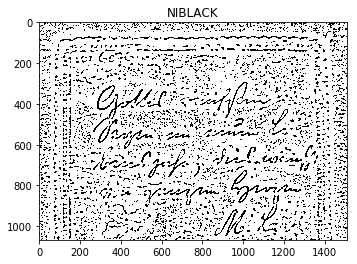

[[1319835, 178895], [41935, 70505]]
0.28269847634322376 0.627045535396656 0.3897026309971258


In [143]:
window_size = 25
thresh_niblack = threshold_niblack(org_img, window_size=window_size, k=0.8)
binary_niblack = org_img > thresh_niblack
plt.imshow(binary_niblack, cmap='gray')
plt.title('NIBLACK')
plt.show()

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, binary_niblack):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_niblack = [[tn, fp], [fn, tp]]
precision_niblack = tp / (tp + fp)
recall_niblack = tp / (tp + fn)
f_niblack = 2*(precision_niblack*recall_niblack)/(precision_niblack+recall_niblack)
print(cm_niblack)
print(precision_niblack, recall_niblack, f_niblack)

# Algorithm 6 - Ridler-Calvard

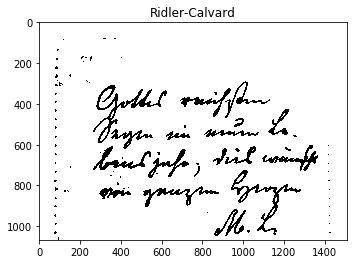

[[1491073, 7657], [7642, 104798]]
0.9319105419945756 0.9320348630380647 0.9319726983703506


In [144]:
thresh_rc = rc(org_img)
binary_rc = (org_img > thresh_rc)
plt.imshow(binary_rc, cmap='gray')
plt.title("Ridler-Calvard")
plt.show()

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(gt_img, binary_rc):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_rc = [[tn, fp], [fn, tp]]
precision_rc = tp / (tp + fp)
recall_rc = tp / (tp + fn)
f_rc = 2*(precision_rc*recall_rc)/(precision_rc+recall_rc)
print(cm_rc)
print(precision_rc, recall_rc, f_rc) 

# Algorithm 7 - Adaptive Thresholding Mean

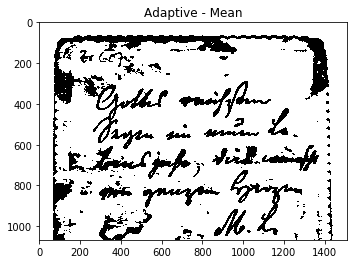

[[1498730, 0], [1012, 111428]]
1.0 0.9909996442547137 0.9954794789786839


In [147]:
binary_ada_mean = cv2.adaptiveThreshold(org_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,231, 10)
plt.imshow(binary_ada_mean, cmap='gray')
plt.title("Adaptive - Mean")
plt.show()

for i in range(len(binary_ada_mean)):
    for j in range(len(binary_ada_mean[i])):
        if binary_ada_mean[i][j] == 0:
            binary_ada_mean[i][j] = False
        else:
            binary_ada_mean[i][j] = True

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(im_cmp, binary_ada_mean):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_ada = [[tn, fp], [fn, tp]]
precision_ada = tp / (tp + fp)
recall_ada = tp / (tp + fn)
f_ada = 2*(precision_ada*recall_ada)/(precision_ada+recall_ada)
print(cm_ada)
print(precision_ada, recall_ada, f_ada) 

# Algorithm 8 - Adaptive Thresholding Guassian

In [ ]:
binary_ada_gauss = cv2.adaptiveThreshold(org_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(binary_ada_gauss, cmap='gray')
plt.title("Adaptive - Gaussian")
plt.show()

for i in range(len(binary_ada_gauss)):
    for j in range(len(binary_ada_gauss[i])):
        if binary_ada_gauss[i][j] == 0:
            binary_ada_gauss[i][j] = False
        else:
            binary_ada_gauss[i][j] = True

# Calculating Accuracy

tp = 0
tn = 0
fp = 0
fn = 0
for x, y in zip(im_cmp, binary_ada_gauss):
    for i, j in zip(x, y):
        if i == False and j == False:
            tp += 1
        elif i == True and j == False:
            fp += 1
        elif i == False and j == True:
            fn += 1
        else:
            tn += 1

cm_ada_mean = [[tn, fp], [fn, tp]]

precision_ada_gauss = tp / (tp + fp)
recall_ada_gauss = tp / (tp + fn)
f_ada_gauss = 2*(precision_ada_gauss*recall_ada_gauss)/(precision_ada_gauss+recall_ada_gauss)
print(cm_ada_gauss)
print(precision_ada_gauss, recall_ada_gauss, f_ada_gauss) 